In [269]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.transforms import CenterCrop, ToTensor, Compose
import seaborn as sb
import pandas as pd
import yaml
import os
from transformers import BertTokenizer, BertTokenizerFast
from transformers import BeitFeatureExtractor 
from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision import transforms
from transformers import BertForSequenceClassification, BeitForImageClassification, Trainer, TrainingArguments,  BeitConfig, BertConfig
import wandb
from transformers.models.bert.modeling_bert import SequenceClassifierOutput
from torch.nn import CrossEntropyLoss
from transformers import CLIPModel, CLIPConfig
from transformers import ViltModel, ViltConfig
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification, BertModel
import torch
import torch.nn as nn

In [270]:
class MMTD(torch.nn.Module):
    def __init__(self, bert_cfg=BertConfig(), beit_cfg=BeitConfig(), bert_pretrain_weight=None, beit_pretrain_weight=None):
        super(MMTD, self).__init__()

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.text_encoder = BertForSequenceClassification.from_pretrained(bert_pretrain_weight) if bert_pretrain_weight is not None else BertForSequenceClassification(bert_cfg)
        self.image_encoder = BeitForImageClassification.from_pretrained(beit_pretrain_weight) if beit_pretrain_weight is not None else BeitForImageClassification(beit_cfg)

        
        self.text_encoder.config.output_hidden_states = True        
        self.image_encoder.config.output_hidden_states = True


        self.multi_modality_transformer_layer = torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True)
        
        self.pooler = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.Tanh()
        )
              
        self.classifier = torch.nn.Linear(768, 2)
        self.num_labels = 2
        # self.dropout = torch.nn.Dropout(p=0.1)
        

    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None, pixel_values=None, url_input_ids=None, url_token_type_ids=None, url_attention_mask=None, Obfuscation=None, labels=None, length=None, digit_proportion=None, unique_word_count=None, special_char_proportion=None, sentiment_polarity=None, lexical_diversity=None, average_word_length=None):
        
        text_outputs = self.text_encoder(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)        
        image_outputs = self.image_encoder(pixel_values=pixel_values)

        text_last_hidden_state = text_outputs.hidden_states[12]
        image_last_hidden_state = image_outputs.hidden_states[12]

 

        text_last_hidden_state += torch.zeros(text_last_hidden_state.size()).to(self.device)
        image_last_hidden_state += torch.ones(image_last_hidden_state.size()).to(self.device)
        
        fuse_hidden_state = torch.cat([text_last_hidden_state, image_last_hidden_state], dim=1)      

        outputs = self.multi_modality_transformer_layer(fuse_hidden_state)        
        outputs = self.pooler(outputs[:, 0, :])          
        logits = self.classifier(outputs)

        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )

In [271]:
def save_config(config: dict, save_path: str):
    with open(save_path, 'w') as f:
        f.write(yaml.dump(config, allow_unicode=True))


def metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"acc": acc}


class EvalMetrics:
    def __init__(self, save_path=None, save_name=None, heatmap=False, target_names=None):
        self.save_path = save_path
        self.save_name = save_name
        self.heatmap = heatmap
        self.classes = target_names

    def __call__(self, eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        scores = torch.softmax(torch.from_numpy(logits).float(), dim=1)
        scores = scores.detach().numpy()
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if self.save_name is not None:
            plt.title('ROC graph of ' + self.save_name)
        else:
            plt.title('ROC graph')

        
        
        classes = self.classes 
        colors = ['navy', 'aqua', 'darkorange', 'cornflowerblue', 'green']


        for i in range(len(classes)):
            fpr, tpr, thresholds = roc_curve(labels, scores[:, i], pos_label=i)
            auc_values = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i],
                     label='ROC curve of {0} (area = {1:0.8f})'''.format(classes[i], auc_values))

        plt.legend(loc="lower right")
        if self.save_name is not None:
            plt.savefig(os.path.join(self.save_path, self.save_name + '_roc.jpg').replace('\\', '/'))
            
        plt.show()

        acc = accuracy_score(labels, predictions)
        report = classification_report(labels, predictions, target_names=classes)
        matrix = confusion_matrix(labels, predictions)
        if self.heatmap:
            sb.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

            if self.save_name is not None:
                plt.title(self.save_name + '_heatmap')
                plt.savefig(os.path.join(self.save_path, self.save_name + '_heatmap.jpg').replace('\\', '/'))
            else:
                plt.title('heatmap')
            plt.show()
        if self.save_name is not None:
            with open(os.path.join(self.save_path, self.save_name + '.txt'), 'w') as f:
                f.write(self.save_name + '\n')
                f.write("acc: " + str(acc))
                f.write("\n\nreport:\n")
                f.write(report)
                f.write("\nconfusion matrix:\n")
                f.write(str(matrix))
        return {"acc": acc}



In [272]:
class SplitData:
    def __init__(self, csv, k_fold, index_start_zero):
        
        if (index_start_zero):
            data = pd.read_csv(csv, index_col=0)
            data = data.sample(frac = 1)
        else:
            data = pd.read_csv(csv)
            data = data.sample(frac = 1)
        
        data.fillna('null', inplace=True)

        quantity = int((len(data) - len(data) % k_fold) / k_fold)
        self.fold_list = [data.iloc[quantity * i:quantity * (i + 1), :] for i in range(k_fold - 1)]
        self.fold_list.append(data.iloc[(k_fold - 1) * quantity:, :])

    def __call__(self):
        test_data = self.fold_list.pop()
        train_data = pd.concat(self.fold_list, ignore_index=True)
        self.fold_list.insert(0, test_data)
        return train_data, test_data

class EDPDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, data_df):
        super(EDPDataset, self).__init__()
        self.data_path = data_path
        self.data = data_df[['text', 'pics', 'labels', 'category', 'taux_obfuscation', 
                             'url', 'type', 'length', 'special_char_proportion', 'average_word_length',  'url_count', 
                             'repeated_chars', 'digit_proportion', 'vowel_consonant_ratio']]


    def __getitem__(self, item):
        
        text = self.data.iloc[item, 0]
        pic_filename = self.data.iloc[item, 1]
        label = self.data.iloc[item, 2]
        category = self.data.iloc[item, 3]
        taux_obfuscation = self.data.iloc[item, 4]
        url = self.data.iloc[item, 5]
        url_type = self.data.iloc[item, 6]
        length = self.data.iloc[item, 7]
        special_char_proportion = self.data.iloc[item, 8]
        average_word_length = self.data.iloc[item, 9]
        url_count = self.data.iloc[item, 10]
        repeated_chars = self.data.iloc[item, 11]
        digit_proportion = self.data.iloc[item, 12]
        vowel_consonant_ratio = self.data.iloc[item, 13]
        

        pic_path = os.path.join(self.data_path, pic_filename).replace('\\', '/')
        pic = Image.open(pic_path)

        return (text, pic, label, category, taux_obfuscation, url, url_type,
                length, special_char_proportion, average_word_length,  url_count, repeated_chars, digit_proportion,vowel_consonant_ratio)

    def __len__(self):
        return len(self.data) 


class EDPCollator:
    def __init__(self, tokenizer=None, feature_extractor=None):
        #self.tokenizer = tokenizer if tokenizer is not None else BertTokenizer.from_pretrained('bert-base-cased')

        self.tokenizer = tokenizer if tokenizer is not None else BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')        
        self.feature_extractor = feature_extractor if feature_extractor is not None else BeitFeatureExtractor.from_pretrained('microsoft/dit-base')
        self.label_encoder_text_category = LabelEncoder()
        self.label_encoder_url_type = LabelEncoder()

    def text_process(self, text_list):
        text_tensor = self.tokenizer(text_list, return_tensors='pt', max_length=256, truncation=True, padding='max_length')
        return text_tensor
    
    def picture_process(self, picture_list):
        pixel_values = self.feature_extractor(picture_list, return_tensors='pt')
        return pixel_values
    
    def __call__(self, data):

        text_list, picture_list, label_list, text_category_list, taux_obf_list, url_list, type_url_list, length_list, special_char_proportion_list, average_word_length_list, url_count_list, repeated_chars_list, digit_proportion_list, vowel_consonant_ratio_list = zip(*data)
      
        #text_list_with_image = [text + " " + image_text for text, image_text in zip(text_list, text_image_list)]
        #text_tensor = self.text_process(list(text_list_with_image))
        text_tensor = self.text_process(list(text_list))


        pixel_values = self.picture_process(picture_list)
        url_tensor = self.text_process(list(url_list))
        
        url_input_ids = url_tensor['input_ids']
        url_token_type_ids = url_tensor['token_type_ids']
        url_attention_mask = url_tensor['attention_mask']
        
        Obfuscation = torch.FloatTensor(taux_obf_list)
        labels = torch.LongTensor(label_list)
      
        length = torch.FloatTensor(length_list)
        special_char_proportion = torch.FloatTensor(special_char_proportion_list)
        average_word_length = torch.FloatTensor(average_word_length_list)
        url_count = torch.FloatTensor(url_count_list)
        repeated_chars = torch.FloatTensor(repeated_chars_list)
        digit_proportion = torch.FloatTensor(digit_proportion_list)
        vowel_consonant_ratio = torch.FloatTensor(vowel_consonant_ratio_list)
 
        inputs = dict()
        inputs.update(text_tensor)
        inputs.update(pixel_values)
        inputs.update({'url_input_ids': url_input_ids,
                'url_token_type_ids': url_token_type_ids,
                'url_attention_mask': url_attention_mask,
                })

        inputs['Obfuscation'] = Obfuscation
        inputs['labels'] = labels
        
        inputs['length'] = length
        inputs['special_char_proportion'] = special_char_proportion
        inputs['average_word_length'] = average_word_length
        inputs['url_count'] = url_count
        inputs['repeated_chars'] = repeated_chars
        inputs['digit_proportion'] = digit_proportion
        inputs['vowel_consonant_ratio'] = vowel_consonant_ratio

        return inputs
    


class EDPTextCollator(EDPCollator):
    def __call__(self, data):
        text_list, picture_list, label_list, text_image_list, text_category_list, taux_obf_list, url_list, type_url_list, length_list, digit_proportion_list, unique_word_count_list, special_char_proportion_list, sentiment_polarity_list, lexical_diversity_list, average_word_length_list = zip(*data)

        #text_list_with_image = [text + " " + image_text for text, image_text in zip(text_list, text_image_list)]
        #text_tensor = self.text_process(list(text_list_with_image))
        text_tensor = self.text_process(list(text_list))

        labels = torch.LongTensor(label_list)
        
        # Création des trois tenseurs pour les entrées
        text_input_ids = text_tensor['input_ids']
        text_token_type_ids = text_tensor['token_type_ids']
        text_attention_mask = text_tensor['attention_mask']
        
        # Création du dictionnaire d'entrées
        inputs = dict()
        
        # Mise à jour des entrées avec les trois tenseurs pour l'URL 
        inputs.update({'input_ids': text_input_ids,
                       'token_type_ids': text_token_type_ids,
                       'attention_mask': text_attention_mask,
                       })
        inputs['labels']= labels
        
        inputs.pop('url_input_ids', None)
        inputs.pop('url_token_type_ids', None)
        inputs.pop('url_attention_mask', None)
        inputs.pop('pixel_values', None)
        inputs.pop('Obfuscation', None)
        inputs.pop('text_category', None)
        inputs.pop('type_url', None)
        return inputs


class EDPPictureCollator(EDPCollator):
    def __call__(self, data):
        text_list, picture_list, label_list, text_category_list, taux_obf_list, url_list, type_url_list, length_list, digit_proportion_list, unique_word_count_list, special_char_proportion_list, sentiment_polarity_list, lexical_diversity_list, average_word_length_list = zip(*data)
        pixel_values = self.feature_extractor(picture_list, return_tensors='pt')
        labels = torch.LongTensor(label_list)
        inputs = dict()
        inputs.update(pixel_values)
        inputs['labels'] = labels
        return inputs


class EDPCategoryCollator:
    def __init__(self, tokenizer=None):
        #self.tokenizer = tokenizer if tokenizer is not None else BertTokenizer.from_pretrained('bert-base-cased')     
        self.tokenizer = tokenizer if tokenizer is not None else BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')           
        self.label_encoder_category = LabelEncoder()

    def text_process(self, text_list):
        text_tensor = self.tokenizer(text_list, return_tensors='pt', max_length=256, truncation=True, padding='max_length')
        
        return text_tensor
    
    def __call__(self, data):
        text_list, labels_list = zip(*data)
        text_tensor = self.text_process(list(text_list))
        
        input_ids = text_tensor['input_ids']
        token_type_ids = text_tensor['token_type_ids']
        attention_mask = text_tensor['attention_mask']
        
        category_encoded = self.label_encoder_category.fit_transform(labels_list)  
        labels = torch.LongTensor(category_encoded)  
        inputs = dict()       
        inputs.update({'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask,
                })
        inputs['labels'] = labels       
        return inputs

class EDPUrlCollator:
    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer if tokenizer is not None else BertTokenizerFast.from_pretrained('bert-base-multilingual-cased')   
        self.label_encoder_url_type = LabelEncoder()

    def text_process(self, url_list):
        url_tensor = self.tokenizer(url_list, return_tensors='pt', max_length=256, truncation=True, padding='max_length')
        return url_tensor
    
    def __call__(self, data):
        url_list, labels_list = zip(*data)
        url_tensor = self.text_process(list(url_list))
        
        url_input_ids = url_tensor['input_ids']
        url_token_type_ids = url_tensor['token_type_ids']
        url_attention_mask = url_tensor['attention_mask']
        
        url_type_encoded = self.label_encoder_url_type.fit_transform(labels_list)  
        labels = torch.LongTensor(url_type_encoded)  
        inputs = dict()       
        inputs.update({'input_ids': url_input_ids,
                'token_type_ids': url_token_type_ids,
                'attention_mask': url_attention_mask,
                })
        inputs['labels'] = labels       
        return inputs
    
class Extractor:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, data):
        return torch.squeeze(self.feature_extractor(data, return_tensors="pt").pixel_values)


class Email_category_dataset(torch.utils.data.Dataset):
    def __init__(self, data_df):
        
        data_df = data_df[['text', 'category']] 
        self.cat_df =  data_df.rename(columns={"category": "labels"})
 
    def __getitem__(self, item):
        
        text = self.cat_df.iloc[item, 0]
        label = self.cat_df.iloc[item, 1]
                
        return text, label 

    def __len__(self):
        return len(self.cat_df)


class Email_image_dataset(ImageFolder):
    def __getitem__(self, item):
        data, label = super().__getitem__(index=item)
        
        return {"pics": data, "labels": torch.LongTensor([label])}


class Email_url_dataset(torch.utils.data.Dataset):
    def __init__(self, data_df):
        
        data_df = data_df[['url', 'type']] 
        self.url_df =  data_df.rename(columns={"type": "labels"})
 
    def __getitem__(self, item):
        
        url = self.url_df.iloc[item, 0]
        label = self.url_df.iloc[item, 1]
                
        return url, label 

    def __len__(self):
        return len(self.url_df) 
    
class Email_text_dataset(torch.utils.data.Dataset):
    def __init__(self, data_df):
        self.data = data_df[['text', 'labels']] 
     
    def __getitem__(self, item):
        
        text = self.data.iloc[item, 0]
        label = self.data.iloc[item, 1]                
        return text, label 

    def __len__(self):
        return len(self.data) 
    
class EDPTextCollator:
    def __init__(self, tokenizer=None):
        self.tokenizer = tokenizer if tokenizer is not None else BertTokenizer.from_pretrained('bert-base-cased')      

    def text_process(self, text_list):
        text_tensor = self.tokenizer(text_list, return_tensors='pt', max_length=256, truncation=True, padding='max_length')
        return text_tensor
    
    def __call__(self, data):
        text_list, labels_list = zip(*data)
        text_tensor = self.text_process(list(text_list))
        
        input_ids = text_tensor['input_ids']
        token_type_ids = text_tensor['token_type_ids']
        attention_mask = text_tensor['attention_mask']
       
        labels = torch.LongTensor(labels_list)  
        inputs = dict()       
        inputs.update({'input_ids': input_ids,
                'token_type_ids': token_type_ids,
                'attention_mask': attention_mask,
                })
        inputs['labels'] = labels       
        return inputs
    
class EDPImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, data_df):
        self.data_path = data_path
        self.data = data_df[['pics', 'labels']]

    def __getitem__(self, item):
        
        pic_filename = self.data.iloc[item, 0]
        label = self.data.iloc[item, 1]       
        print(pic_path)
        
        pic_path = os.path.join(self.data_path, pic_filename).replace('\\', '/')
        
        pic = Image.open(pic_path)

        return (pic, label)

    def __len__(self):
        return len(self.data) 

In [273]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

fold = 3

dataset_path = 'C:/codes_data/MMTD/V2/HSMDData15.csv'
main_path_output = 'C:/codes_data/MMTD/V2/output/'
image_folder = 'C:/codes_data/MMTD/V2/pics4'

index_start_zero = False
split_data = SplitData(dataset_path, fold, index_start_zero)
train_df, test_df = split_data()   
NUM_EPOCHS = 25
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
NUM_EXECUTIONS = 1

In [274]:
class HMSD(nn.Module):
    def __init__(self, bert_cfg=BertConfig(), beit_cfg=BeitConfig(), bert_pretrain_weight=None, beit_pretrain_weight=None, url_pretrain_weight=None, text_category_pretrain_weight=None):
        super(HMSD, self).__init__()

        # Initialize encoders

        self.text_encoder = BertForSequenceClassification.from_pretrained(bert_pretrain_weight) if bert_pretrain_weight is not None else BertForSequenceClassification(bert_cfg)
        self.image_encoder = BeitForImageClassification.from_pretrained(beit_pretrain_weight) if beit_pretrain_weight is not None else BeitForImageClassification(beit_cfg)
        self.text_category_encoder = BertForSequenceClassification.from_pretrained(bert_pretrain_weight) if bert_pretrain_weight is not None else BertForSequenceClassification(bert_cfg)
        self.url_encoder = BertForSequenceClassification.from_pretrained(url_pretrain_weight) if url_pretrain_weight is not None else BertForSequenceClassification(bert_cfg)


        # Ensure encoders output hidden states
        self.text_encoder.config.output_hidden_states = True
        self.image_encoder.config.output_hidden_states = True
        self.text_category_encoder.config.output_hidden_states = True
        self.url_encoder.config.output_hidden_states = True

        self.multi_modality_transformer_layer = torch.nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True)
        
        txt_img_dim = 8
        self.pooler = torch.nn.Sequential(
            torch.nn.Linear(768, txt_img_dim),
            torch.nn.Tanh()
        )
        self.dropout = torch.nn.Dropout(p=0.2)   
        self.classifier1 = nn.Linear(txt_img_dim+8, 2)                
        self.classifier2 = nn.Linear(txt_img_dim, 2)

        self.num_labels = 2
        self.combine_everything = False
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def forward(self, input_ids=None, token_type_ids=None, attention_mask=None, pixel_values=None, url_input_ids=None, url_token_type_ids=None,
                 url_attention_mask=None, Obfuscation=None, labels=None, length=None, special_char_proportion=None, average_word_length=None, 
                 url_count=None, repeated_chars=None, digit_proportion=None, vowel_consonant_ratio=None):    

        
            # Encodeurs pour le texte
        text_outputs = self.text_encoder(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        image_outputs = self.image_encoder(pixel_values=pixel_values)
        text_category_outputs = self.text_category_encoder(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        url_outputs = self.url_encoder(input_ids=url_input_ids, token_type_ids=url_token_type_ids, attention_mask=url_attention_mask)

        text_last_hidden_state = text_outputs.hidden_states[12]
        image_last_hidden_state = image_outputs.hidden_states[12]
        text_category_last_hidden_state = text_category_outputs.hidden_states[12]
        url_last_hidden_state = url_outputs.hidden_states[12]

        text_last_hidden_state += torch.zeros(text_last_hidden_state.size()).to(self.device)
        image_last_hidden_state += torch.ones(image_last_hidden_state.size()).to(self.device)
        text_category_last_hidden_state += torch.zeros(text_category_last_hidden_state.size()).to(self.device)
        url_last_hidden_state += torch.zeros(url_last_hidden_state.size()).to(self.device)        
            
        fuse_hidden_state = torch.cat([text_last_hidden_state, image_last_hidden_state], dim=1)      

        outputs = self.multi_modality_transformer_layer(fuse_hidden_state)        
        outputs = self.pooler(outputs[:, 0, :]) 
        
        other_features = torch.cat([                     
            Obfuscation.unsqueeze(1),
            length.unsqueeze(1),
            special_char_proportion.unsqueeze(1),
            average_word_length.unsqueeze(1),  
            url_count.unsqueeze(1),  
            repeated_chars.unsqueeze(1),  
            digit_proportion.unsqueeze(1),
            vowel_consonant_ratio.unsqueeze(1)], dim=-1)  

        if self.combine_everything:

            outputs = torch.cat([outputs,other_features], dim=-1)    
            outputs = self.dropout(outputs)
            #print(outputs.shape)
            logits = self.classifier1(outputs) 

        else:
            logits = self.classifier2(outputs)

        loss = None
        
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=None,
            attentions=None,
        )

C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\beit\image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


  0%|          | 0/625 [00:00<?, ?it/s]

{'loss': 0.5627, 'learning_rate': 0.004, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.45618775486946106, 'eval_acc': 0.8437185929648241, 'eval_runtime': 54.4963, 'eval_samples_per_second': 36.516, 'eval_steps_per_second': 1.156, 'epoch': 1.0}
{'loss': 0.4613, 'learning_rate': 0.003, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.4339796006679535, 'eval_acc': 0.8447236180904523, 'eval_runtime': 63.3748, 'eval_samples_per_second': 31.401, 'eval_steps_per_second': 0.994, 'epoch': 2.0}
{'loss': 0.4966, 'learning_rate': 0.002, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.4235094487667084, 'eval_acc': 0.8517587939698492, 'eval_runtime': 47.3383, 'eval_samples_per_second': 42.038, 'eval_steps_per_second': 1.331, 'epoch': 3.0}
{'loss': 0.4532, 'learning_rate': 0.001, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.4250178337097168, 'eval_acc': 0.8502512562814071, 'eval_runtime': 47.4429, 'eval_samples_per_second': 41.945, 'eval_steps_per_second': 1.328, 'epoch': 4.0}
{'loss': 0.4523, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.422390878200531, 'eval_acc': 0.8507537688442212, 'eval_runtime': 47.3892, 'eval_samples_per_second': 41.993, 'eval_steps_per_second': 1.329, 'epoch': 5.0}
{'train_runtime': 817.7066, 'train_samples_per_second': 24.336, 'train_steps_per_second': 0.764, 'train_loss': 0.48522794799804686, 'epoch': 5.0}


C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\beit\image_processing_beit.py:110: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


  0%|          | 0/2500 [00:00<?, ?it/s]

{'loss': 0.4925, 'learning_rate': 0.00475, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/hsmd\checkpoints\fold_1\checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4081055223941803, 'eval_acc': 0.8110552763819096, 'eval_runtime': 47.5818, 'eval_samples_per_second': 41.823, 'eval_steps_per_second': 1.324, 'epoch': 1.0}
{'loss': 0.4416, 'learning_rate': 0.0045000000000000005, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/hsmd\checkpoints\fold_1\checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.326255738735199, 'eval_acc': 0.8582914572864322, 'eval_runtime': 47.4829, 'eval_samples_per_second': 41.91, 'eval_steps_per_second': 1.327, 'epoch': 2.0}
{'loss': 0.3666, 'learning_rate': 0.00425, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/hsmd\checkpoints\fold_1\checkpoint-375 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2877054810523987, 'eval_acc': 0.8577889447236181, 'eval_runtime': 47.9134, 'eval_samples_per_second': 41.533, 'eval_steps_per_second': 1.315, 'epoch': 3.0}
{'loss': 0.3343, 'learning_rate': 0.004, 'epoch': 4.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/hsmd\checkpoints\fold_1\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.26339951157569885, 'eval_acc': 0.8778894472361809, 'eval_runtime': 48.1271, 'eval_samples_per_second': 41.349, 'eval_steps_per_second': 1.309, 'epoch': 4.0}
{'loss': 0.3203, 'learning_rate': 0.00375, 'epoch': 5.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/hsmd\checkpoints\fold_1\checkpoint-625 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.24340736865997314, 'eval_acc': 0.8804020100502512, 'eval_runtime': 63.0979, 'eval_samples_per_second': 31.538, 'eval_steps_per_second': 0.998, 'epoch': 5.0}
{'loss': 0.2994, 'learning_rate': 0.0034999999999999996, 'epoch': 6.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.22848600149154663, 'eval_acc': 0.9276381909547738, 'eval_runtime': 64.593, 'eval_samples_per_second': 30.808, 'eval_steps_per_second': 0.975, 'epoch': 6.0}
{'loss': 0.2891, 'learning_rate': 0.0032500000000000003, 'epoch': 7.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.22173874080181122, 'eval_acc': 0.8949748743718593, 'eval_runtime': 64.3991, 'eval_samples_per_second': 30.901, 'eval_steps_per_second': 0.978, 'epoch': 7.0}
{'loss': 0.28, 'learning_rate': 0.003, 'epoch': 8.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.22790125012397766, 'eval_acc': 0.8984924623115578, 'eval_runtime': 63.1559, 'eval_samples_per_second': 31.509, 'eval_steps_per_second': 0.998, 'epoch': 8.0}
{'loss': 0.2819, 'learning_rate': 0.0027500000000000003, 'epoch': 9.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.20086531341075897, 'eval_acc': 0.9457286432160804, 'eval_runtime': 63.4432, 'eval_samples_per_second': 31.367, 'eval_steps_per_second': 0.993, 'epoch': 9.0}
{'loss': 0.2685, 'learning_rate': 0.0025, 'epoch': 10.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.19697976112365723, 'eval_acc': 0.949748743718593, 'eval_runtime': 73.1615, 'eval_samples_per_second': 27.2, 'eval_steps_per_second': 0.861, 'epoch': 10.0}
{'loss': 0.2662, 'learning_rate': 0.0022500000000000003, 'epoch': 11.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.18987831473350525, 'eval_acc': 0.9467336683417086, 'eval_runtime': 63.1831, 'eval_samples_per_second': 31.496, 'eval_steps_per_second': 0.997, 'epoch': 11.0}
{'loss': 0.2679, 'learning_rate': 0.002, 'epoch': 12.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.18883869051933289, 'eval_acc': 0.9663316582914573, 'eval_runtime': 63.2893, 'eval_samples_per_second': 31.443, 'eval_steps_per_second': 0.995, 'epoch': 12.0}
{'loss': 0.2636, 'learning_rate': 0.0017499999999999998, 'epoch': 13.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.18357257544994354, 'eval_acc': 0.9658291457286432, 'eval_runtime': 62.8182, 'eval_samples_per_second': 31.679, 'eval_steps_per_second': 1.003, 'epoch': 13.0}
{'loss': 0.2618, 'learning_rate': 0.0015, 'epoch': 14.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.18063092231750488, 'eval_acc': 0.9703517587939698, 'eval_runtime': 64.208, 'eval_samples_per_second': 30.993, 'eval_steps_per_second': 0.981, 'epoch': 14.0}
{'loss': 0.2622, 'learning_rate': 0.00125, 'epoch': 15.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.17464469373226166, 'eval_acc': 0.9673366834170855, 'eval_runtime': 64.2654, 'eval_samples_per_second': 30.965, 'eval_steps_per_second': 0.98, 'epoch': 15.0}
{'loss': 0.2408, 'learning_rate': 0.001, 'epoch': 16.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.17273931205272675, 'eval_acc': 0.9547738693467337, 'eval_runtime': 63.8496, 'eval_samples_per_second': 31.167, 'eval_steps_per_second': 0.987, 'epoch': 16.0}
{'loss': 0.2358, 'learning_rate': 0.00075, 'epoch': 17.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.1677270233631134, 'eval_acc': 0.9587939698492463, 'eval_runtime': 54.6909, 'eval_samples_per_second': 36.386, 'eval_steps_per_second': 1.152, 'epoch': 17.0}
{'loss': 0.2377, 'learning_rate': 0.0005, 'epoch': 18.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.1682099550962448, 'eval_acc': 0.9517587939698492, 'eval_runtime': 48.2084, 'eval_samples_per_second': 41.279, 'eval_steps_per_second': 1.307, 'epoch': 18.0}
{'loss': 0.2356, 'learning_rate': 0.00025, 'epoch': 19.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.1656293123960495, 'eval_acc': 0.9562814070351758, 'eval_runtime': 53.8489, 'eval_samples_per_second': 36.955, 'eval_steps_per_second': 1.17, 'epoch': 19.0}
{'loss': 0.2493, 'learning_rate': 0.0, 'epoch': 20.0}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.16603834927082062, 'eval_acc': 0.9562814070351758, 'eval_runtime': 52.5215, 'eval_samples_per_second': 37.889, 'eval_steps_per_second': 1.2, 'epoch': 20.0}
{'train_runtime': 3752.2447, 'train_samples_per_second': 21.214, 'train_steps_per_second': 0.666, 'train_loss': 0.2947607765197754, 'epoch': 20.0}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Error: [Errno 2] No such file or directory: 'C:/codes_data/MMTD/V2/output/hsmd/results/fold_1_roc.jpg'


eval/acc,▂▂▃▃▃▁▃▃▄▄▆▅▅▇▇▇████▇▇▇▇▇█
eval/loss,█▇▇▇▇▇▅▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁
eval/runtime,▂▃▁▁▁▁▁▁▁▃▃▃▃▃▅▃▃▃▃▃▃▂▁▂▂█
eval/samples_per_second,▅▃███████▃▃▃▃▃▁▃▃▃▃▃▃▅█▆▆▇
eval/steps_per_second,▅▃███████▃▃▃▃▃▁▃▃▃▃▃▃▅█▆▆▇
train/epoch,▁▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇█████
train/learning_rate,▇▇▅▄▂▁██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▆▅▅▄▄▅▄▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
train/total_flos,▁▁
train/train_loss,█▁


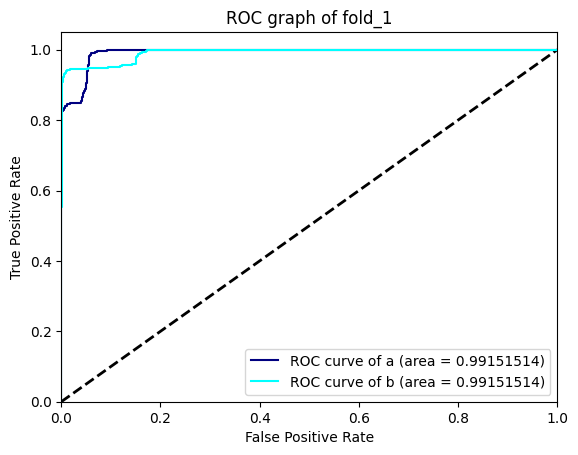

In [276]:
from torch.optim import AdamW

bertTEXT_checkpoint_path = os.path.join(main_path_output, 'bertTEXT', 'checkpoints').replace('\\', '/')
dit_checkpoint_path = os.path.join(main_path_output, 'dit', 'checkpoints').replace('\\', '/')
bertURL_checkpoint_path = os.path.join(main_path_output, 'bertURL', 'checkpoints').replace('\\', '/')
bertCAT_checkpoint_path  = os.path.join(main_path_output, 'bertCAT', 'checkpoints').replace('\\', '/')

if __name__ == '__main__':
    for i in range(NUM_EXECUTIONS):
          
        train_dataset = EDPDataset(image_folder, train_df)
        test_dataset = EDPDataset(image_folder, test_df)

        checkpoints = os.listdir(os.path.join(bertTEXT_checkpoint_path, f'fold{i+1}').replace('\\', '/'))
        bertTEXT_checkpoint = os.path.join(bertTEXT_checkpoint_path, f'fold{i+1}', checkpoints[-1]).replace('\\', '/')

        checkpoints = os.listdir(os.path.join(dit_checkpoint_path, f'fold{i+1}').replace('\\', '/'))
        dit_checkpoint = os.path.join(dit_checkpoint_path, f'fold{i+1}', checkpoints[-1]).replace('\\', '/')

        checkpoints = os.listdir(os.path.join(bertURL_checkpoint_path, f'fold{i+1}').replace('\\', '/'))
        bertURL_checkpoint = os.path.join(bertURL_checkpoint_path, f'fold{i+1}', checkpoints[-1]).replace('\\', '/')

        checkpoints = os.listdir(os.path.join(bertCAT_checkpoint_path, f'fold{i+1}').replace('\\', '/'))
        bertCAT_checkpoint = os.path.join(bertCAT_checkpoint_path, f'fold{i+1}', checkpoints[-1]).replace('\\', '/')
        
        names = ['a', 'b']
        model = HMSD(bert_pretrain_weight=bertTEXT_checkpoint, beit_pretrain_weight=dit_checkpoint, text_category_pretrain_weight=bertCAT_checkpoint, url_pretrain_weight=bertURL_checkpoint)
        #model = MMTD(bert_pretrain_weight=bertTEXT_checkpoint, beit_pretrain_weight=dit_checkpoint)

        for p in model.text_encoder.parameters():
            p.requires_grad = False
        for p in model.image_encoder.parameters():
            p.requires_grad = False       
        for p in model.text_category_encoder.parameters():
            p.requires_grad = False
        for p in model.url_encoder.parameters():
            p.requires_grad = False
       
        optimizer = AdamW(model.parameters(), lr=5e-3)

        args = TrainingArguments(
            output_dir=os.path.join(main_path_output, 'hsmd', 'checkpoints', f'fold_{i + 1}'),
            logging_dir=os.path.join(main_path_output, 'hsmd', 'log'),
            logging_strategy='epoch',
            per_device_train_batch_size= TRAIN_BATCH_SIZE,
            per_device_eval_batch_size = VALID_BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            weight_decay=0.0,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            auto_find_batch_size=False,
            overwrite_output_dir=True,
            save_total_limit=5,
            remove_unused_columns=False,
            report_to=["wandb"],
        )

        args.num_train_epochs= 5
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            optimizers=(optimizer, None),
            data_collator=EDPCollator(),
            compute_metrics=metrics,
        )
        
        trainer.train()

        model.combine_everything = True 
        args.num_train_epochs= 20
        
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            optimizers=(optimizer, None),
            data_collator=EDPCollator(),
            compute_metrics=metrics,
        )
        trainer.train()
       
        try:            
            train_acc = trainer.evaluate(eval_dataset=train_dataset)
            train_result = {'train_acc': train_acc['eval_acc'], 'train_loss': train_acc['eval_loss']}
            trainer.compute_metrics = EvalMetrics(os.path.join(main_path_output, 'hsmd', 'results'), f'fold_{i + 1}', True, target_names = names)
            wandb.log(train_result)

            test_acc = trainer.evaluate(eval_dataset=test_dataset)
            test_result = {'test_acc': test_acc['eval_acc'], 'test_loss': test_acc['eval_loss']}
            wandb.log(test_result)

            wandb.config = args.to_dict()
            save_config(args.to_dict(), os.path.join(main_path_output, 'hsmd', 'configs', f'fold_{i + 1}.yaml'))
        except FileNotFoundError as e:
            print(f"Error: {e}")
        finally:
            wandb.finish()
            del model, args, trainer   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 0.5241, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertTEXT/checkpoints/fold1\checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4670894145965576, 'eval_acc': 0.7834170854271357, 'eval_runtime': 10.2158, 'eval_samples_per_second': 194.796, 'eval_steps_per_second': 6.167, 'epoch': 1.0}
{'loss': 0.4439, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertTEXT/checkpoints/fold1\checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4410802721977234, 'eval_acc': 0.7939698492462312, 'eval_runtime': 10.6535, 'eval_samples_per_second': 186.794, 'eval_steps_per_second': 5.914, 'epoch': 2.0}
{'loss': 0.4122, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertTEXT/checkpoints/fold1\checkpoint-375 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4286060333251953, 'eval_acc': 0.7964824120603015, 'eval_runtime': 10.6127, 'eval_samples_per_second': 187.512, 'eval_steps_per_second': 5.936, 'epoch': 3.0}
{'train_runtime': 193.2087, 'train_samples_per_second': 61.798, 'train_steps_per_second': 1.941, 'train_loss': 0.4600808614095052, 'epoch': 3.0}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

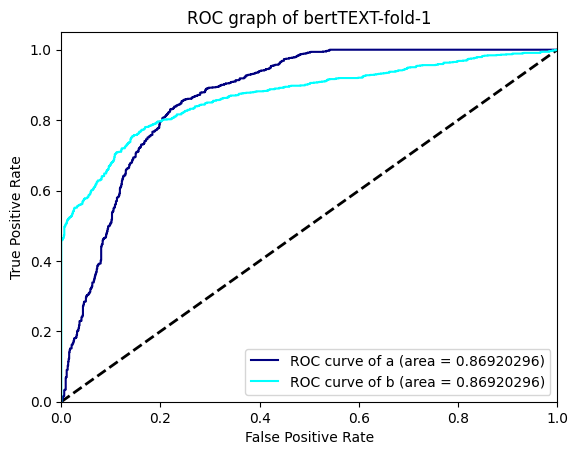

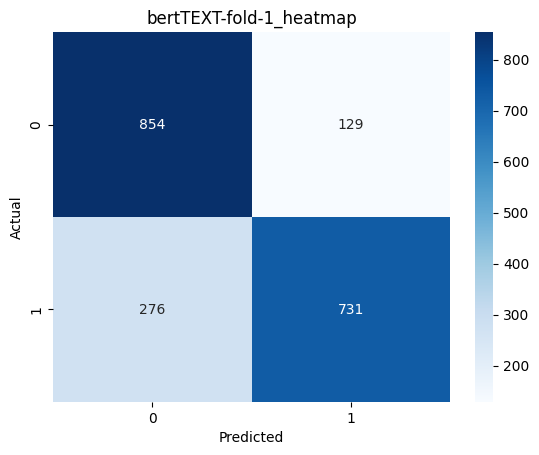

Error: [Errno 2] No such file or directory: 'C:/codes_data/MMTD/V2/output/bertTEXT/configs/bertTEXT-fold-1.yaml'


eval/acc,▁▃▃█▃
eval/loss,█▆▅▁▅
eval/runtime,▁▁▁█▁
eval/samples_per_second,█▃▃▆▁
eval/steps_per_second,█▃▃▅▁
test_acc,▁
test_loss,▁
train/epoch,▁▁▅▅█████
train/global_step,▁▁▅▅███████
train/learning_rate,█▅▁
train/loss,█▃▁


In [ ]:
if __name__ == '__main__':
    for i in range(NUM_EXECUTIONS):
        wandb.init(project='HMSD')
        wandb.run.name = 'bertTEXT-fold-' + str(i + 1)
        train_df, test_df = split_data()

        names = ['a', 'b'] 
        train_dataset = Email_text_dataset( train_df)
        test_dataset = Email_text_dataset( test_df)

        model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2).to(DEVICE)

        args = TrainingArguments(
            output_dir=main_path_output + 'bertTEXT/checkpoints/fold' + str(i + 1),
            logging_dir=main_path_output + 'bertTEXT/log',
            logging_strategy='epoch',
            learning_rate=5e-5,
            per_device_train_batch_size= TRAIN_BATCH_SIZE,
            per_device_eval_batch_size = VALID_BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            run_name=wandb.run.name,
            auto_find_batch_size=False,
            overwrite_output_dir=True,
            save_total_limit=8,
            remove_unused_columns=False,
            report_to=["wandb"],
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=EDPTextCollator(),
            compute_metrics=metrics,
        )

        try:
            trainer.train()
            train_acc = trainer.evaluate(eval_dataset=train_dataset)
            train_result = {'train_acc': train_acc['eval_acc'], 'train_loss': train_acc['eval_loss']}
            wandb.log(train_result)

            trainer.compute_metrics = EvalMetrics(main_path_output + 'bertTEXT/results', wandb.run.name, True, target_names = names)
            test_acc = trainer.evaluate(eval_dataset=test_dataset)
            test_result = {'test_acc': test_acc['eval_acc'], 'test_loss': test_acc['eval_loss']}
            wandb.log(test_result)
            wandb.config = args.to_dict()

            save_config(args.to_dict(), os.path.join(main_path_output + 'bertTEXT/configs', wandb.run.name + '.yaml').replace('\\', '/'))
        except FileNotFoundError as e:
            print(f"Error: {e}")
        finally:
            wandb.finish()
            del model, args, trainer

In [ ]:

if __name__ == '__main__':
    for i in range(NUM_EXECUTIONS):
        wandb.init(project='HMSD')
        wandb.run.name = 'dit-fold-' + str(i + 1)

        train_df, test_df = split_data()
        names = ['a', 'b'] 
        train_dataset = EDPDataset(os.path.join(image_folder), train_df)
        test_dataset = EDPDataset(os.path.join(image_folder), test_df)
        model = BeitForImageClassification.from_pretrained('microsoft/dit-base').to(DEVICE)

        args = TrainingArguments(
            output_dir = main_path_output+'dit/checkpoints/fold' + str(i + 1),
            logging_dir = main_path_output + 'dit/log', 
            logging_strategy='epoch',
            per_device_train_batch_size= TRAIN_BATCH_SIZE,
            per_device_eval_batch_size = VALID_BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            # fp16=True,
            learning_rate=5e-5,
            remove_unused_columns=False,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            run_name=wandb.run.name,
            auto_find_batch_size=False,
            overwrite_output_dir=True,
            save_total_limit=8,
            report_to=["wandb"],
        ) 
    
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=EDPPictureCollator(),
            compute_metrics=metrics,
        )
        try:
            
            trainer.train()
            
            train_acc = trainer.evaluate(eval_dataset=train_dataset)
            train_result = {'train_acc': train_acc['eval_acc'], 'train_loss': train_acc['eval_loss']}
            wandb.log(train_result)

            trainer.compute_metrics = EvalMetrics(main_path_output + 'dit/results', wandb.run.name, True, target_names = names)
            test_acc = trainer.evaluate(eval_dataset=test_dataset)
            test_result = {'test_acc': test_acc['eval_acc'], 'test_loss': test_acc['eval_loss']}
            wandb.log(test_result)

            wandb.config = args.to_dict()
            save_config(args.to_dict(), os.path.join(main_path_output + 'dit/configs', wandb.run.name + '.yaml').replace('\\', '/'))
            
        except FileNotFoundError as e:
            print(f"Error: {e}")   
        finally:
            wandb.finish()
            del model, args, trainer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ms-allili (larivia_2024). Use `wandb login --relogin` to force relogin


C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\allimo01\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformer

  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 0.4775, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/dit/checkpoints/fold1\checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.438411682844162, 'eval_acc': 0.8472361809045226, 'eval_runtime': 29.8752, 'eval_samples_per_second': 66.61, 'eval_steps_per_second': 2.109, 'epoch': 1.0}


eval/acc,▁
eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁
train/loss,▁
eval/acc,0.84724
eval/loss,0.43841


KeyboardInterrupt: 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ms-allili (larivia_2024). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/141 [00:00<?, ?it/s]

{'loss': 0.7283, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.18288342654705048, 'eval_acc': 0.9515477792732167, 'eval_runtime': 3.1596, 'eval_samples_per_second': 235.154, 'eval_steps_per_second': 7.596, 'epoch': 1.0}
{'loss': 0.2635, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.18821096420288086, 'eval_acc': 0.9582772543741588, 'eval_runtime': 3.1928, 'eval_samples_per_second': 232.714, 'eval_steps_per_second': 7.517, 'epoch': 2.0}
{'loss': 0.0432, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/24 [00:00<?, ?it/s]

{'eval_loss': 0.14925289154052734, 'eval_acc': 0.9703903095558546, 'eval_runtime': 3.3027, 'eval_samples_per_second': 224.968, 'eval_steps_per_second': 7.267, 'epoch': 3.0}
{'train_runtime': 65.5519, 'train_samples_per_second': 67.824, 'train_steps_per_second': 2.151, 'train_loss': 0.3450001503558869, 'epoch': 3.0}


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

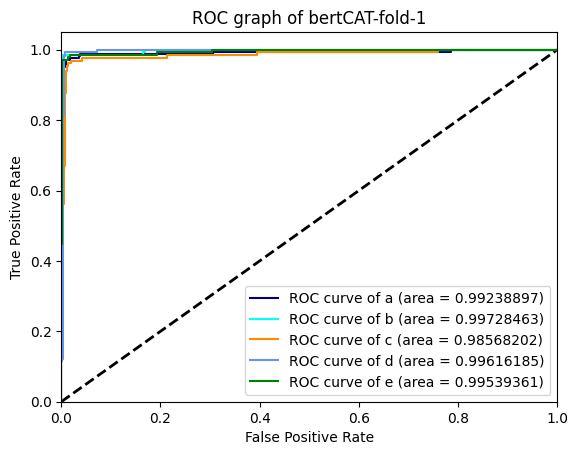

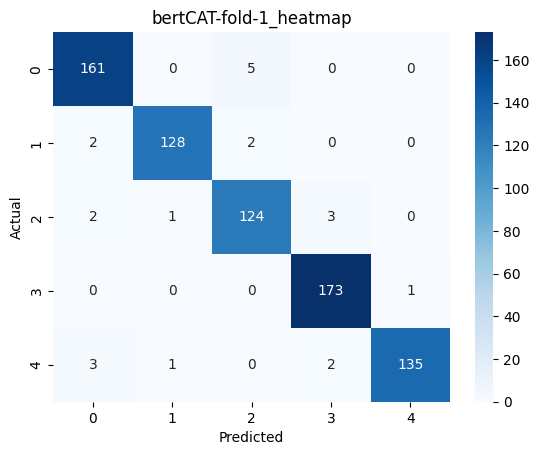

Error: [Errno 2] No such file or directory: 'C:/codes_data/MMTD/V2/output/bertCAT/configs/bertCAT-fold-1.yaml'


eval/acc,▁▂▄█▄
eval/loss,██▆▁▆
eval/runtime,▁▁▁█▂
eval/samples_per_second,█▇▆▅▁
eval/steps_per_second,█▇▆▄▁
test_acc,▁
test_loss,▁
train/epoch,▁▁▅▅█████
train/global_step,▁▁▅▅███████
train/learning_rate,█▅▁
train/loss,█▃▁


In [ ]:
cat_dataset_path = 'C:/codes_data/MMTD/V2/bbc-text.csv'
split_data = SplitData(cat_dataset_path, fold, index_start_zero)

if __name__ == '__main__':
    for i in range(NUM_EXECUTIONS):
        wandb.init(project='HMSD')
        wandb.run.name = 'bertCAT-fold-' + str(i + 1)
        train_df, test_df = split_data()

        names = ['a', 'b','c','d','e'] 
        train_dataset = Email_category_dataset(train_df)
        test_dataset = Email_category_dataset(test_df)

        model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5).to(DEVICE)

        args = TrainingArguments(
            output_dir=main_path_output + 'bertCAT/checkpoints/fold' + str(i + 1),
            logging_dir=main_path_output + 'bertCAT/log',
            logging_strategy='epoch',
            learning_rate=5e-5,
            per_device_train_batch_size= TRAIN_BATCH_SIZE,
            per_device_eval_batch_size = VALID_BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            run_name=wandb.run.name,
            auto_find_batch_size=False,
            overwrite_output_dir=True,
            save_total_limit=8,
            remove_unused_columns=False,
            report_to=["wandb"],
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=EDPCategoryCollator(),
            compute_metrics=metrics,
        )

        try:
            trainer.train()
            train_acc = trainer.evaluate(eval_dataset=train_dataset)
            train_result = {'train_acc': train_acc['eval_acc'], 'train_loss': train_acc['eval_loss']}
            wandb.log(train_result)

            trainer.compute_metrics = EvalMetrics(main_path_output + 'bertCAT/results', wandb.run.name, True, target_names = names)
            test_acc = trainer.evaluate(eval_dataset=test_dataset)
            test_result = {'test_acc': test_acc['eval_acc'], 'test_loss': test_acc['eval_loss']}
            wandb.log(test_result)

            wandb.config = args.to_dict()

            save_config(args.to_dict(), os.path.join(main_path_output + 'bertCAT/configs', wandb.run.name + '.yaml').replace('\\', '/'))
        except FileNotFoundError as e:
            print(f"Error: {e}")
        finally:
            wandb.finish()
            del model, args, trainer

In [ ]:
if __name__ == '__main__':
    
    for i in range(NUM_EXECUTIONS):
        wandb.init(project='HMSD')
        wandb.run.name = 'bert-fold-' + str(i + 1)
        train_df, test_df = split_data()   

        train_dataset = Email_url_dataset(train_df)
        test_dataset = Email_url_dataset(test_df)

        names = ['a', 'b', 'c', 'd'] 

        model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=4).to(DEVICE)
        args = TrainingArguments(
            output_dir=main_path_output + 'bertURL/checkpoints/fold' + str(i + 1),
            logging_dir=main_path_output + 'bertURL/log',
            logging_strategy='epoch',
            learning_rate=5e-5,
            per_device_train_batch_size= TRAIN_BATCH_SIZE,
            per_device_eval_batch_size = VALID_BATCH_SIZE,
            num_train_epochs=NUM_EPOCHS,
            save_strategy="epoch",
            evaluation_strategy="epoch",
            load_best_model_at_end=True,
            dataloader_num_workers=0,
            dataloader_pin_memory=True,
            run_name=wandb.run.name,
            auto_find_batch_size=False,
            overwrite_output_dir=True,
            save_total_limit=8,
            remove_unused_columns=False,
            report_to=["wandb"],
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            data_collator=EDPUrlCollator(),
            compute_metrics=metrics,
        )

        try:
            trainer.train()

            train_acc = trainer.evaluate(eval_dataset=train_dataset)
            train_result = {'train_acc': train_acc['eval_acc'], 'train_loss': train_acc['eval_loss']}
            wandb.log(train_result)
            trainer.compute_metrics = EvalMetrics(main_path_output + 'bertURL/results', wandb.run.name, True, target_names = names)    
                        
            test_acc = trainer.evaluate(eval_dataset=test_dataset)
            
            test_result = {'test_acc': test_acc['eval_acc'], 'test_loss': test_acc['eval_loss']}
            wandb.log(test_result)
            
            wandb.config = args.to_dict()
            save_config(args.to_dict(), os.path.join(main_path_output + 'bertURL/configs', wandb.run.name + '.yaml').replace('\\', '/'))
            
            
        except FileNotFoundError as e:
            print(f"Error: {e}")
        finally:
            wandb.finish()
            del model, args, trainer

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ms-allili (larivia_2024). Use `wandb login --relogin` to force relogin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/375 [00:00<?, ?it/s]

{'loss': 0.4833, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertURL/checkpoints/fold1\checkpoint-125 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.24457871913909912, 'eval_acc': 0.9226130653266331, 'eval_runtime': 7.1775, 'eval_samples_per_second': 277.254, 'eval_steps_per_second': 8.777, 'epoch': 1.0}
{'loss': 0.2043, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertURL/checkpoints/fold1\checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.15583400428295135, 'eval_acc': 0.9603015075376884, 'eval_runtime': 7.2715, 'eval_samples_per_second': 273.67, 'eval_steps_per_second': 8.664, 'epoch': 2.0}
{'loss': 0.0869, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/63 [00:00<?, ?it/s]

Checkpoint destination directory C:/codes_data/MMTD/V2/output/bertURL/checkpoints/fold1\checkpoint-375 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.16510282456874847, 'eval_acc': 0.9592964824120603, 'eval_runtime': 7.3297, 'eval_samples_per_second': 271.498, 'eval_steps_per_second': 8.595, 'epoch': 3.0}
{'train_runtime': 151.315, 'train_samples_per_second': 78.908, 'train_steps_per_second': 2.478, 'train_loss': 0.25816684977213544, 'epoch': 3.0}


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]